# DYNAMIC MODEL NOTEBOOK

<img src="batman.jpg">

This notebook seeks to do the dynamic modeling of our crime analysis. Specifically, the dynamic portion involves doing crime resolution on a time-adjusted basis by predicting when and where a crime will occur. Specifically, for a given location and a given time, we try to predict whether or not a crime will occur there at that moment. 

We begin by loading in the data into the appropriate formats, and then defining some functions for expected costs, accuracy etc. and then dive into our models. For our models, we try four different sets of models to determine if a crime is going to occur in a given lat, long at a given time. We see fairly great accuracy and savings here for a given set of classifiers and spend the bulk of our analysis here. To wrap up, we also try to tell how well these models do in predicting the number of crimes, and try to get more accurate numbers on how much money each crime prevented saves us based on the nature of the crimes at that instance. 

In [431]:
%matplotlib inline
from IPython.display import Image
import csv
import numpy as np
import random
import sklearn
import pickle
import sys
import math
import matplotlib.pyplot as plt

Build a crime dictionary keyed by the Time, Latitude and Longitude and valued by whether or not a crime occurred during that time. Some of the key data we care about is when/where the crime occured and how severe the crime was (which we coded as the crime's "score").

# Load in the Data and Define Necessary Functions

The below will load in all the crime data into a dictionary crimeDictionary. This dictionary is keyed by (location, time) and valued by all the attributes of the crime. 

In [2]:
# with open('JRcleaningcontinued.csv', 'rU') as csvfile:
with open('crime_costs.csv', 'rU') as csvfile:
    reader = csv.DictReader(csvfile)
    crimeDictionary = {}
    all_lat_longs = []
    count = 0
    for row in reader:
        try:
            loc = row['Location'].split(',')
#             lat = float(loc[0][1:5])
#             lon = float(loc[1][1:6])
            
            lat = round(float(loc[0][1:8]), 1)
            lon = round(float(loc[1][1:9]), 1)
            
#             key = (float(row['EPOCH_TRUNC']), (float(row['LATITUDE'][:4]), float(row['LONGITUDE'][:5])))
            key = (float(row['EPOCH_TRUNC']), (lat, lon))
#             all_lat_longs.append((float(row['LATITUDE'][:4]), float(row['LONGITUDE'][:5])))
            all_lat_longs.append((lat, lon))
            if key in crimeDictionary:
                crimeDictionary[key].append(row)
            else:
                crimeDictionary[key] = [row]
        except:
            print row['Location']
            print loc
            print lat
            print lon
    all_lat_longs = set(all_lat_longs)

In [3]:
print len(all_lat_longs)

7


Lets also take a quick look at how a single crime in the dictionary looks. 

In [4]:
crimeDictionary[crimeDictionary.keys()[0]][0]

{'COMPNOS': '120516219.0',
 'COST': '50',
 'DATETIME': '2012-08-19 09:09:00',
 'DATETIME_TRUNC': '2012-08-19 09:00:00',
 'DAY_WEEK': 'Sunday',
 'DOMESTIC': 'No',
 'EPOCH': '1345381740.0',
 'EPOCH_TRUNC': '1345381200.0',
 'FROMDATE': '08/19/2012 09:09:00 AM',
 'INCIDENT_TYPE_DESCRIPTION': 'val',
 'LATITUDE': '42.35162134',
 'LONGITUDE': '-71.06872456',
 'Location': '(42.35162134, -71.06872456)',
 'MAIN_CRIMECODE': 'VAL',
 'Month': '8',
 'NatureCode': 'ILLPRK',
 'REPORTINGAREA': '118',
 'REPTDISTRICT': 'A1',
 'SCORE': '1',
 'SHIFT': 'Day',
 'STREETNAME': 'PARK PLAZA',
 'Shooting': 'No',
 'UCRPART': 'Part Two',
 'Unnamed: 0': '10503',
 'WEAPONTYPE': 'Unarmed',
 'X': '772743.942',
 'XSTREETNAME': 'CHARLES ST S',
 'Y': '2953454.502',
 'Year': '2012'}

Lets see how long the crime data goes for.

In [5]:
crime_Dates = map(lambda x: x[0], crimeDictionary.keys())
print "crime starts at date : ", min(crime_Dates)
print "crime stops at date : ", max(crime_Dates)

crime starts at date :  1341723600.0
crime stops at date :  1439222400.0


The start date is July 8 2012. 
The end date is 10 August 2015.

Now, we are going to load in all the weather data. In the next few parts, we will construct our weatherDictionary with the parameters clock (time of day), temperature, pressure, humidity, visibility, precipitation Intensity and probability.

In [6]:
weatherFyle = open('JRcompleteweatherdata.pkl')
weatherDF = pickle.load(weatherFyle)

Get the following attributes for weather dictionary, keeping in mind:
#minTime = 1341115200, July 2012 
#maxTime = 1443495600, Sept 29, 2015 
#Attributes: LATITUDE, LONGITUDE, time, temperature, pressure, humidity, visibility, precipIntensity, precipProbability

In [7]:
weatherDict = {}
weatherLocations = []
for x in weatherDF.iterrows():
    key = (x[1]['time'], (float(x[1]['LATITUDE']), float(x[1]['LONGITUDE'])))
    weather_loc = (x[1]['LATITUDE'], x[1]['LONGITUDE'])
    if (x[1]['LATITUDE'], x[1]['LONGITUDE']) in all_lat_longs and (key[0] > 1341723600) and (key[0] < 1439222400.0) :
        clock = str(x[1]['DATETIME_TRUNC'])
        clock_lst = clock.split(" ")
        clock = float(clock_lst[1][0:2])
        weatherDict[key] = {'clock': clock, 'temp': x[1]['temperature'], 'pressure': x[1]['pressure'], 'humidity': x[1]['humidity'], 'humidity': x[1]['visibility'], 'precipIntensity': x[1]['precipIntensity'], 'precipProbability': x[1]['precipProbability']}
    weatherLocations.append(weather_loc)
weatherLocations = set(weatherLocations)
for x in all_lat_longs:
    if x not in weatherLocations:
        print x

In [8]:
len(weatherDict)

189574

In [9]:
weatherDict[weatherDict.keys()[0]]

{'clock': 12.0,
 'humidity': 4.98,
 'precipIntensity': 0.0471,
 'precipProbability': 0.73,
 'pressure': 1017.69,
 'temp': 67.71}

Now that we have the weather data loaded in as a weatherDictionary, we want to load in the data for Boston Holidays in the exact same format as our weatherDictionary. Specifically, for each hour and location in our data set, we want to code in the value 0 if there was school and work that day, code in the value 1 if there was no school but work that day (i.e. a snow day or summer break) and code in the value 2 if there was no school/work that day (i.e. a weekend)

In [10]:
schoolOffdict = {}
with open('JRschooldayoff.csv', 'rU') as csvfile:
    reader = csv.DictReader(csvfile)
    min_date = 9999999999
    max_date = None
    for row in reader:
        epoch = float(row['EPOCH'])
        min_date = min(epoch, min_date)
        max_date = max(epoch, max_date)
        dayoff = int(row['DAYOFF'])
        for latlong in all_lat_longs:
            if epoch > 1341723600.0 and epoch < 1439222400.0:
                schoolOffdict[(epoch, latlong)] = dayoff

In [11]:
print len(schoolOffdict)
print min_date
print max_date
print all_lat_longs

189553
1341115200.0
1443582000.0
set([(42.2, -71.1), (42.4, -71.2), (42.4, -71.1), (42.4, -71.0), (42.3, -71.0), (42.3, -71.1), (42.3, -71.2)])


Make sure that if we have some keys in our weather dictionary that aren't covered in our schoolOffDict, then we should just fill in that dictionary with some average value (in this case 0). This only happens around 20 times in 189,000+ samples.

In [12]:
for k in weatherDict.keys():
    counter = 1
    if k not in schoolOffdict:
        schoolOffdict[k] = 0

Now, lets load in the unemployment data into our unemploymentDictionary. This uses the exact same pattern as we used in schoolDaysOff and is keyed and valued similarily (but with unemployment rate as a different). 

In [13]:
unemploymentDict = {}
with open('JRhourlyurate.csv', 'rU') as csvfile:
    reader = csv.DictReader(csvfile)
    min_date = 9999999999
    max_date = None
    for row in reader:
        epoch = float(row['EPOCH'])
        min_date = min(epoch, min_date)
        max_date = max(epoch, max_date)
        unemployment_rate = float(row['URATE'])
        for latlong in all_lat_longs:
            if epoch > 1341723600.0 and epoch < 1439222400.0:
                unemploymentDict[(epoch, latlong)] = unemployment_rate

In [14]:
len(unemploymentDict)

189553

In [15]:
for k in weatherDict.keys():
    counter = 1
    if k not in unemploymentDict:
        unemploymentDict[k] = 5.2

In [16]:
len(schoolOffdict) == len(unemploymentDict) == len(weatherDict)
# inFile = open('schoolOffdict.pkl', 'rb')
# schoolOffdict = pickle.load(inFile)

True

Now, as a final step lets consider the our predicted 'danger' level of each location that comes out of our static model. 

In [17]:
dangerFyle = open('dangerDict.pkl')
dangerDict = pickle.load(dangerFyle)

dangerDict uses latitude, longitude pairs that are up to 2 decimal places each. For the dynamic model, we want to just use 1 decimal place in lat, long so we take the average danger level of all the ratings in the relevant category.

In [18]:
newDangerDict = {}
for k in dangerDict:
    lat, lon = k
    lat = round(lat, 1)
    lon = round(lon, 1)
    if (lat, lon) in newDangerDict:
        newDangerDict[(lat, lon)].append(dangerDict[k])
    else:
        newDangerDict[(lat, lon)] = [dangerDict[k]]

for k in newDangerDict:
    newDangerDict[k] = np.mean(newDangerDict[k])

The below will calculate the PAYOUT costs. This includes the PAYOUT of a true positive, true negative and false positive and false negative of our predictions based on the cost of crime data we found online. We also use the fact that the median salary of police officers in the United States is 25 dollars an hour, and decide that we can try to prevent crimes by having 4 additional officer cars for an additional two hours in the locations we predict.

In [209]:
#Simplifying Assumption: Additional Cars will be able to prevent / reduce the cost by 50%.
#This is made up by the fact that we severely underestimate the cost of crime to just be economic loss to victims.
#http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2835847/

costOfCrimeNational = 15000000000.0
numCrimesNational = 23000000.0
avgCostOfCrime = costOfCrimeNational/numCrimesNational

costOfPolicePatrol = 25
numHours = 2
numCars = 4
costOfPolice = numCars*numHours*costOfPolicePatrol

print "The Average Cost of Crime is : ", avgCostOfCrime
print "The Average Cost of Increased Policing is : ", costOfPolice

PAYOUT_OF_TRUE_POSITIVE = avgCostOfCrime
PAYOUT_OF_TRUE_NEGATIVE = 0
PAYOUT_OF_FALSE_POSITIVE = -costOfPolice

#The following is a quick calculation that helps us best understand how to penalize false negatives:
#Boston has 2000+ police officers, potentially working 8 hr shifts so < 700 active at a given time. 
#At any given time, we assume 25% of them are on patrol, so 175 patrol officers. Over 7 geographic lat longs,
#we imagine at any given hour there are roughly ~25 officers patroling. We are re-placing 4 of them for two hours
#to a different lat, long and since we predicted that this area wouldn't have crime (and it really did), we imagine
#that we reduced the efficacy of the Boston Police Department to respond to that crime by (4*2)/25 so that times the
#cost of the crime is our penalty.
#Note, we could not have included a penalty here to avoid thinking about the opportunity costs of missed crimes and 
#gotten higher results, but we wanted to make sure our classifier penalized false negatives sufficiently. 

PAYOUT_OF_FALSE_NEGATIVE = -(float(4*2)/25)*avgCostOfCrime

The Average Cost of Crime is :  652.173913043
The Average Cost of Increased Policing is :  200


Build the X and Y matrices for our predictions. X are all attributes that include weather, and Y are the attributes that will be binary, 1 if a crime occurred and 0 if it did not.

We also build a cost list here that will help us at the very end calculate the total cost of our savings. 

In [354]:
X = []
Y = []
costsLst = []
for k in weatherDict.keys():
    if k in crimeDictionary:
        Y.append(1)
        costsLst.append((1, k))
    else:
        Y.append(0)
        costsLst.append((0, k))
    features = []
    for item in weatherDict[k].keys():
        features.append(weatherDict[k][item])
    features.append(schoolOffdict[k])
    features.append(unemploymentDict[k])
    diffKey = k[1]
    features.append(newDangerDict[diffKey])
    X.append(features)

Create our training and test sets pased on random partitions of the data. Our training set is approximately 80% of our total data and our test set is 20% of the total data:

In [355]:
random.seed(1)
X_shuffled = sorted(X, key=lambda k: random.random())
random.seed(1)
Y_shuffled = sorted(Y, key=lambda k: random.random())
random.seed(1)
costsLstOrdered = sorted(costsLst, key=lambda k: random.random())
X_train = X_shuffled[0:150000]
Y_train = Y_shuffled[0:150000]
X_test = X_shuffled[150000:]
Y_test = Y_shuffled[150000:]
costsTrain = costsLstOrdered[0:150000]
costsTest = costsLstOrdered[150000:]

The below function will calculate the true/false positive/negative matrix given a Prediction List and the corresponding correct values list.

In [212]:
def getAccuracy(Preds, Y):
    falsePositive = 0
    falseNegative = 0
    truePositive = 0
    trueNegative = 0
    for i in xrange(len(Preds)):
        j = i
        if Preds[i] == Y[j]:
            if Preds[i] == 1:
                truePositive += 1
            elif Preds[i] == 0:
                trueNegative += 1
            else:
                print Preds[i]
        else:
            if Preds[i] is 1:
                falsePositive += 1
            else:
                falseNegative += 1
#     print "The True Positive Rate is : ", truePositive
#     print "The True Negative Rate is : ", trueNegative
#     print "The False Positive Rate is : ", falsePositive
#     print "The False Negative Rate is : ", falseNegative
    return truePositive, trueNegative, falsePositive, falseNegative

In [213]:
def expectedCost(Y_preds, Y_true):
    tp, tn, fp, fn = getAccuracy(Y_preds, Y_true)
    #If there's a true positive, add the savings, subtract the cost of police, everything else is straightforward
    payout = tp*PAYOUT_OF_TRUE_POSITIVE + tp*PAYOUT_OF_FALSE_POSITIVE + tn * PAYOUT_OF_TRUE_NEGATIVE + fp*PAYOUT_OF_FALSE_POSITIVE + fn*PAYOUT_OF_FALSE_NEGATIVE
    return payout

Define a function return the percentage of correct classifications given

In [214]:
def get_correct_percentage(tp, tn, fp, fn):
    return float(tp + tn)/(tp + tn + fp + fn)

Get the optimal savings: What would the cost be on our Test Set if you could predict every crime perfectly?

In [215]:
optimalSavings = 0
for i in Y_test:
    optimalSavings += avgCostOfCrime*i + PAYOUT_OF_FALSE_POSITIVE*i
optimalSavings

4628904.347826341

In [216]:
def thresholdPredictions(threshold, probs):
    return map(lambda x: 1 if x[1] >= threshold else 0, probs)

Ok now that we have our data loaded in and some helper functions defined, we will try to figure out which machine learning classifier is the __ best __ at predicting a binary response: YES OR NO, will a crime occur at a particular location at a particular time?

# Predicting if Crime will Happen or Not

Using the data we have from above, we will attempt to optimize 4 different machine learning algorithms to predict whether or not crime will happen at a location, time combination. However, as in a previous problem set, we are not necessairly interested in having the most accurate classifiers because "no crime" occurs far more often than "crime" (about 83% versus 17%). Instead, we are optimizing for expected cost. 

## Train our SVMs

As we noted in our meeting with our TF, training requires an incredible amount of time that isn't feasible with our restarts and the number of other classifiers we seek to train. As we discussed in our meeting, there isn't a great workaround to this that is immediately available (especially since we need to do an even more computationally expensive things for our SVM later of converting our max-margin estimates to actual probabilities), so we only train on the first 10,000 elements of our training set rather than the entire thing.

Fortunately, this still helps us form a basis for analysis on this project. 

In [217]:
from sklearn import svm
svmClf = svm.SVC(probability=True)
#svmClf.fit(X_train, Y_train)

The following set of functions optimizes the parameters of the SVM: 

In [218]:
def optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    new_clf = sklearn.grid_search.GridSearchCV(clf, parameters, cv=n_folds, score_func=score_func)
    new_clf.fit(X, y)
    return new_clf.best_estimator_

In [219]:
from sklearn.metrics import confusion_matrix
def classify(clf, parameters, X_train, Y_train, X_test, Y_test, score_func=None, n_folds=5): 
    if parameters:
        clf = optimize(clf, parameters, X_train, Y_train, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(X_train, Y_train)
    training_accuracy = clf.score(X_train, Y_train)
    test_accuracy = clf.score(X_test, Y_test)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(Y_test, clf.predict(X_test))
    print "########################################################"
    return clf

In [220]:
X_train_svm = X_train[:10000]
Y_train_svm = Y_train[:10000]
# svmClf.fit(X_train_svm, Y_train_svm)
optimalSVM = classify(svmClf, {'C': [0.01, 0.1, 1, 10]}, X_train_svm, Y_train_svm, X_test, Y_test, score_func=expectedCost)
optimalSVM

############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.78
[[26154  3183]
 [ 5702  4535]]
########################################################


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Notice above the differential between our accuracy on the training data and on the test data. 

For below: As a reminder, following output gives us our: truePositive, trueNegative, falsePositive, falseNegative. There are predictions in every category except for "False Positives", which is perhaps not too surprising given that positive results don't make up as much of our dataset. 

In [221]:
svmClf.fit(X_train_svm, Y_train_svm)
svmPreds = svmClf.predict(X_test)
getAccuracy(svmPreds, Y_test)

(4535, 26154, 0, 8885)

Lets see what the expected cost of this type of classifier is: 

In [222]:
expectedCost(svmPreds, Y_test)

196347.82608695654

Not bad, but I think we can do better. In HW3, the problem set mentioned that SVMs have an ability to translate their maximum-margin distance into a probability calculation (alibiet with not the most accurate translation all the time). At the time, we did not do it because it is very computationally expensive and takes a long time to run.

However, for our report we do extract these probabilities and conduct our analysis to see which probability threshold is most rewarding. 

In [223]:
ProbPredsSVM = optimalSVM.predict_proba(X_test)

Lets try this for just the twenty percent threshold and see how we do

In [254]:
twentyPercentThreshold = thresholdPredictions(0.2, ProbPredsSVM)
costTwentyPercentSVM = expectedCost(twentyPercentThreshold, Y_test)
costTwentyPercentSVM

1715443.4782608692

Well that seems like we are heading in the right direction. So, now lets do it in the legitimate manner and go through every single possible value for the threshold.

########################
1841295.65217
0.16
(8824, 20068, 9269, 1413)


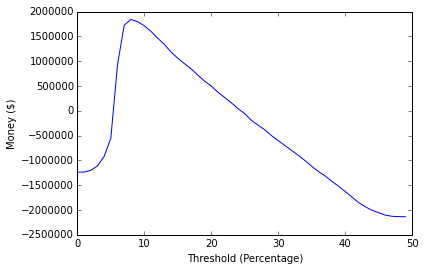

In [293]:
best_payout_SVM = -99999999
best_t_SVM = 0
threshold_payouts = []
for t in np.arange(0.00, 1.0, 0.02):
    t_p = thresholdPredictions(t, ProbPredsSVM)
    tp, tn, fp, fn = getAccuracy(t_p, Y_test)
    payout = expectedCost(t_p, Y_test)
    #payout = tp*PAYOUT_OF_TRUE_POSITIVE + tn * PAYOUT_OF_TRUE_NEGATIVE + fp*PAYOUT_OF_FALSE_POSITIVE + fn*PAYOUT_OF_FALSE_NEGATIVE
    if payout >= best_payout_SVM:
        best_payout_SVM = payout
        best_t_SVM = t
    threshold_payouts.append(payout)
print "########################"
print best_payout_SVM
print best_t_SVM
print getAccuracy(thresholdPredictions(best_t_SVM, ProbPredsSVM), Y_test)
plt.plot(threshold_payouts)
plt.ylabel('Money ($)')
plt.xlabel('Threshold (Percentage)')
plt.show()

Great! Now we know that our SVM performs the best when we translate the margins into probabilities and classify "YES" crime at a 16% threshold. This gives us savings to Boston of $1.8 Million! 

Let's adopt a similar approach to see how the rest of our classifiers do...

## Logistic Regression

Overall, we will be using a very similar framework to above so it should hopefully be easy to follow now.

Fit a logistic regression using it.

In [255]:
from sklearn.linear_model import LogisticRegression
logClf = LogisticRegression()
logClf.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [227]:
optimalLogClf = do_classify(logClf, {'C': [0.01, 0.1, 1, 10]}, X_train, Y_train, X_test, Y_test, score_func=expectedCost)

############# based on standard predict ################
Accuracy on training data: 0.77
Accuracy on test data:     0.77
[[26106  3231]
 [ 5868  4369]]
########################################################


In [256]:
logPredictions = optimalLogClf.predict(X_test)

In [257]:
simpleCostLogReg = expectedCost(logPredictions, Y_test)
simpleCostLogReg

76626.08695652196

Hmm. This is not good, so lets try the threshold approach again. 

In [258]:
ProbPredsLog = optimalLogClf.predict_proba(X_test)

The below code just tells us the Threshold that gives us the best ACCURACY (though remember we care more about dollar savings!). It is an interesting result that in this case the threshold is 0.5 but we can mostly ignore the following cells for the sake of our report (other than it being an interesting result) and go straight to the one that optimizes the cash.

In [232]:
best_accuracy = 0
best_t = 0
for t in np.arange(0.1, 0.98, 0.2):
    t_p = thresholdPredictions(t, ProbPredsLog)
    tp, tn, fp, fn = getAccuracy(t_p, Y_test)
    accuracy = float((tn + tp))/(tp + tn + fp + fn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_t = t
print best_accuracy
print best_t
print "########################"
print getAccuracy(thresholdPredictions(best_t, ProbPredsLog), Y_test)

0.770076312731
0.5
########################
(4369, 26106, 3231, 5868)


########################
1945800.0
0.18
(9289, 19054, 10283, 948)


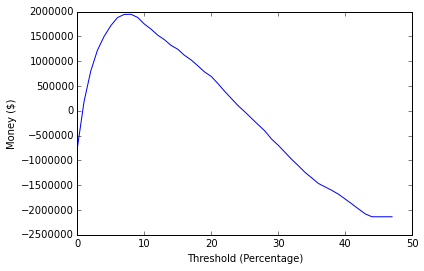

In [294]:
best_payout_log = -99999999
best_t_log = 0
threshold_payouts = []
for t in np.arange(0.02, 0.98, 0.02):
    t_p = thresholdPredictions(t, ProbPredsLog)
    tp, tn, fp, fn = getAccuracy(t_p, Y_test)
    payout = expectedCost(t_p, Y_test)
    if payout >= best_payout_log:
        best_payout_log = payout
        best_t_log = t
    threshold_payouts.append(payout)
print "########################"
print best_payout_log
print best_t_log
print getAccuracy(thresholdPredictions(best_t_log, ProbPredsLog), Y_test)
plt.plot(threshold_payouts)
plt.ylabel('Money ($)')
plt.xlabel('Threshold (Percentage)')
plt.show()

For the Logistic Regression, the best probability threshold is slightly higher than in the SVM at 0.18 and even saves more money at $1,945,800! Not bad, but can we do better?

## Naive Bayes

In [234]:
from sklearn import naive_bayes
naiveGBclf = naive_bayes.GaussianNB()
naiveGBclf.fit(X_train, Y_train)

GaussianNB()

Lets get some basic stats that are automatically collected when we create a Naive Bayes Gaussian Classifier and then report on them. These are perhaps helpful to be the first things we look at when we curated this data set. 

In [235]:
print "the prior probabilities for the classes are : ", naiveGBclf.class_prior_
print "There are ", naiveGBclf.class_count_[0], " instances of Class 0 (No Crime)"
print "There are  ", naiveGBclf.class_count_[1], " instances of Class 1 (Crime)"

the prior probabilities for the classes are :  [ 0.74129333  0.25870667]
There are  111194.0  instances of Class 0 (No Crime)
There are   38806.0  instances of Class 1 (Crime)


Doesn't seem that there are any real hyper-parameters to tune for the Naive Bayes classifier so we can go ahead and dive straight into the predictions and utility there. Afterwards, we can do the same thing as above and analyze thresholds. 

In [236]:
naiveBayesPreds = naiveGBclf.predict(X_test)

Check how many times we predicted a crime was going to occur

In [237]:
print "The number of predicted crimes were : ", sum(naiveBayesPreds)
print "The number of actual crimes was : ", sum(Y_test)

The number of predicted crimes were :  11807
The number of actual crimes was :  10237


Calculate the overall accuracy of our Naive Bayes Classifier, comparing it on the training set to the test set.

In [238]:
naiveGBclf.score(X_train, Y_train)

0.76460666666666666

In [239]:
naiveGBclf.score(X_test, Y_test)

0.7642391469146409

The expected cost from just using the Naive Bayes approach:

In [240]:
simpleCostNB = expectedCost(naiveBayesPreds, Y_test)
simpleCostNB

927339.1304347825

Lets optimize over our threshold probabilities as we did for our SVM and Logistic Regression and see how we do relative to those:

In [241]:
ProbPredsNaiveBayes = naiveGBclf.predict_proba(X_test)
ProbPredsNaiveBayes

array([[  6.70370462e-01,   3.29629538e-01],
       [  6.88210492e-01,   3.11789508e-01],
       [  9.99993083e-01,   6.91675997e-06],
       ..., 
       [  9.99979146e-01,   2.08540182e-05],
       [  9.99436488e-01,   5.63512056e-04],
       [  6.05992322e-01,   3.94007678e-01]])

########################
2292365.21739
0.14
(9916, 18715, 10622, 321)


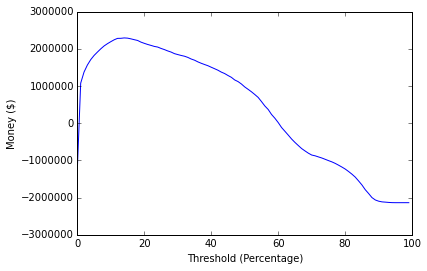

In [292]:
best_payout_NB = -99999999
best_t_NB = 0
thresholds = []
threshold_payouts = []
for t in np.arange(0.00, 1.0, 0.01):
    t_p = thresholdPredictions(t, ProbPredsNaiveBayes)
    tp, tn, fp, fn = getAccuracy(t_p, Y_test)
    payout = expectedCost(t_p, Y_test)
    if payout >= best_payout_NB:
        best_payout_NB = payout
        best_t_NB = t
    thresholds.append(t)
    threshold_payouts.append(payout)
print "########################"
print best_payout_NB
print best_t_NB
print getAccuracy(thresholdPredictions(best_t_NB, ProbPredsNaiveBayes), Y_test)
plt.plot(threshold_payouts)
plt.ylabel('Money ($)')
plt.xlabel('Threshold (Percentage)')
plt.show()

Wow! Using a similar threshold to our SVM approach, our Naive Bayes model actually ends up saving us $2,292,365 over our testing timeline. There's no way we can do better, is there?

## Random Forest

In [409]:
from sklearn.ensemble import RandomForestClassifier

In [410]:
rfclf = RandomForestClassifier()
rfclf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Random forest has some interesting results that I want to highlight here. Take a look at the accuracy on the training set versus the test set. Clearly not optimal. 

In [411]:
rfclf.score(X_train, Y_train)

0.9912266666666667

In [412]:
rfclf.score(X_test, Y_test)

0.87317430636276339

In [413]:
defaultRFPreds = rfclf.predict(X_test)
simpleRFcost = expectedCost(defaultRFPreds, Y_test)
simpleRFcost

2156660.8695652173

Lets see which features the Random Forest classifier says are the most important:

In [414]:
print rfclf.feature_importances_
X_train[0]

[ 0.14304276  0.41052838  0.0325848   0.12727207  0.01052049  0.00912686
  0.01482201  0.06008628  0.19201636]


[14.32, 9.0, 10.0, 1017.78, 0.0, 0.0, 0, 6.0, 4.4375]

Lets go ahead and optimize our Random Forest classifier, on the number of estimators. 

In [415]:
optimalRF = do_classify(rfclf, {'n_estimators': [2,4,6,8,10, 12, 14, 18, 16, 20]}, X_train_svm, Y_train_svm, X_test, Y_test, score_func=expectedCost)

############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.87
[[27463  1874]
 [ 3258  6979]]
########################################################


Note an interesting result: Our random forest predicts perfectly on our training data but is quite different (yet still good) on our test data. Potential risk of overfitting with this calibration.

In [416]:
optimalRF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [417]:
optimalRFPreds = optimalRF.predict(X_test)
print "The score (accuracy) of the optimal RF predictions is : ", optimalRF.score(X_test, Y_test)
print "The expected cost of the optimal RF predictions is : ", expectedCost(optimalRFPreds, Y_test)

The score (accuracy) of the optimal RF predictions is :  0.870318896245
The expected cost of the optimal RF predictions is :  2084695.65217


In [418]:
ProbPredsRF = optimalRF.predict_proba(X_test)

########################
2880043.47826
0.25
(9385, 23408, 5929, 852)


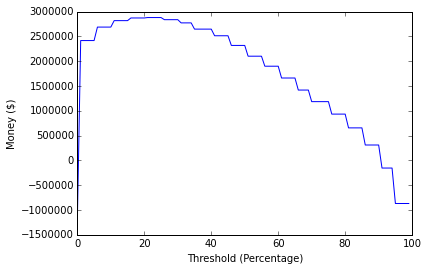

In [419]:
best_payout_rf = -99999999
best_t_rf = 0
threshold_payouts = []
for t in np.arange(0.0, 1.0, 0.01):
    t_p = thresholdPredictions(t, ProbPredsRF)
    tp, tn, fp, fn = getAccuracy(t_p, Y_test)
    payout = expectedCost(t_p, Y_test)
    if payout >= best_payout_rf:
        best_payout_rf = payout
        best_t_rf = t
    threshold_payouts.append(payout)
print "########################"
print best_payout_rf
print best_t_rf
print getAccuracy(thresholdPredictions(best_t_rf, ProbPredsRF), Y_test)
plt.plot(threshold_payouts)
plt.ylabel('Money ($)')
plt.xlabel('Threshold (Percentage)')
plt.show()

The winner becomes clear! We don't actually have to adjust our threshold from a 50% baseline nearly as much using Random Forest as with the other classifiers and can keep it at a comfortable 0.25. This still ends up saving a whopping $2,847,434 over our test set and is certainly high enough for us to declare a high amount of confidence in this classifier. 

# Trying to Predict the Number of Crimes

In the previous part, we tried to predict WHETHER or not a crime would occur in a given time frame at a given location (a binary choice). In this part, we will try to predict the NUMBER of crimes that will occur in a given time frame at a given location.

## Important Note

We discussed this part with our TF because it is very difficult to get a good prediction accuracy on the "Number of Crimes" that occur at a given location at a given time due to the incredibly high variance of hour-to-hour crime. When the number of crimes that happen in a given hour in a lat, long can range anywhere from 0 to dozens, it becomes nearly impossible to predict which number in the range will actually occur, especially for our machine learning classifiers which see barely any probability density differences between the potential classes. 

We agreed with our TF's recommendation to not focus on this part in our report, but would like to include some of our attempts in trying to build a successful model around this below. Please feel free to skim the following section as we attempt a few different models that try to predict the number of crimes and explain what went right and (more often) why the models fail. The results of this section are here more out of interest and academic curiosity and will not be crucial to understanding the final result of our project. 

## Building up Number of Crime Vectors

Build an Num_Crimes Y set that contains the number of crimes with a max of 5 crimes per day.

In [276]:
#rebuild an X and Y now with number of crimes with a max of 20 an hour/loc. This is because 
Y_numCrimes = []
for k in weatherDict.keys():
    if k in crimeDictionary:
        Y_numCrimes.append(min(len(crimeDictionary[k]), 20))
    else:
        Y_numCrimes.append(0)

In [277]:
random.seed(1)
X_num_shuffled = sorted(X, key=lambda k: random.random())
random.seed(1)
Y_shuffled_numCrimes = sorted(Y_numCrimes, key=lambda k: random.random())
X_num_train = X_num_shuffled[0:150000]
Y_num_train = Y_shuffled_numCrimes[0:150000]
X_num_test = X_num_shuffled[150000:]
Y_num_test = Y_shuffled_numCrimes[150000:]

### Trying Using Logistic Regression

In [278]:
logClfNum = LogisticRegression()
logClfNum.fit(X_num_train, Y_num_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [281]:
#How many time/loc combos are there that had 20 or more crimes?
z = map(lambda x: 1 if x > 19 else 0, Y_numCrimes)
sum(z)

1200

In [282]:
numPredProbs = logClfNum.predict_proba(X[150000:])

How many crimes were predicted using this classifier at the conventional 0.5 threshold?

In [283]:
numbercrimesconventional = map(lambda x: 1 if x[0] <= 0.5 else 0, numPredProbs)
sum(numbercrimesconventional)

6625

To make things easier, lets define a function that takes into as an argument a list of probabilities of belonging in each class (from 0 to 20 crimes), and a threshold over which we ignore the possibility of no crime and just get the maximum probability over the rest of the classes.

In [300]:
def get_numCrimes_from_probs(probs, threshold):
    predsFromProbs = []
    for lst in probs:
        if lst[0] >= threshold:
            predsFromProbs.append(np.argmax(lst[1:]))
        else:
            predsFromProbs.append(0)
    return predsFromProbs

In [301]:
numCrimesPredicted = get_numCrimes_from_probs(numPredProbs, 0.18)

In [302]:
print min(numCrimesPredicted), max(numCrimesPredicted)
numCrimesPredicted.count(0)

0 19


35333

The above is actually not too bad as we see we are indeed predicting crimes all the way from 0 to 19 crimes at a given lat, long, hour (and remember technically we reduce the number of crimes that happen to be from 0 to 20). 

So, lets see how good our error rate is by defining a function that computes our error as a function of average distance from true labels (this is essentially the Root Mean Square Error we are familiar with from regressions).

In [316]:
def get_absolute_error(preds, correct):
    error = []
    for i in xrange(len(preds)):
        error.append((correct[i] - preds[i])**2)
    return sum(error)/len(error)

The following subroutine will now optimize the threshold we calculate on whether or not there is a crime using the RMSE. 

In [315]:
best_error = 9999999
best_t_num = 0
best_preds_numCrimes = None
for t in np.arange(0.02, 0.98, 0.01):
    preds = get_numCrimes_from_probs(numPredProbs, t)
    error = get_absolute_error(preds, Y_num_test)
    if error < best_error:
        best_error = error
        best_t_num = t
        best_preds_numCrimes = preds
print "the best error found was : ", best_error
print "the best threshold for this part was : ", best_t_num

the best error found was :  13
the best threshold for this part was :  0.94


An average RMSE of 13 in this context is not very good. Let's keep trying other things..

### Trying using Naive Bayes

In [317]:
naiveGBclfNum = naive_bayes.GaussianNB()
naiveGBclfNum.fit(X_num_train, Y_num_train)

GaussianNB()

In [318]:
print "the prior probabilities for the classes are : ", naiveGBclfNum.class_prior_
print "There number in each class is :  ", naiveGBclfNum.class_count_

the prior probabilities for the classes are :  [ 0.74129333  0.09597333  0.04176     0.02132667  0.01306     0.00934667
  0.00665333  0.00582667  0.00552667  0.00566667  0.00612667  0.00623333
  0.00576     0.00612     0.00564     0.00478     0.00396667  0.00355333
  0.00266667  0.00229333  0.00642667]
There number in each class is :   [ 111194.   14396.    6264.    3199.    1959.    1402.     998.     874.
     829.     850.     919.     935.     864.     918.     846.     717.
     595.     533.     400.     344.     964.]


In [319]:
numCrimesPredictedNB = naiveGBclfNum.predict(X_test)

In [320]:
numProbPredsNB = naiveGBclfNum.predict_proba(X_test)

In [324]:
get_absolute_error(numCrimesPredictedNB, Y_num_test)

18

18 as an average error is certainly not good so lets try our threshold optimization technique. 

In [325]:
best_error = 9999999
best_t_num = 0
best_preds_numCrimes = None
for t in np.arange(0.02, 0.98, 0.01):
    preds = get_numCrimes_from_probs(numProbPredsNB, t)
    error = get_absolute_error(preds, Y_num_test)
    if error < best_error:
        best_error = error
        best_t_num = t
        best_preds_numCrimes = preds
print "the best error found was : ", best_error
print "the best threshold for this part was : ", best_t_num

the best error found was :  14
the best threshold for this part was :  0.93


Not any better than above, so lets try one more time. 

### Trying using Linear Regression

In [326]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_num_train, Y_num_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [327]:
linearPredictions = lin.predict(X_num_test)

In [328]:
print min(linearPredictions), max(linearPredictions)

-3.08811282524 6.37104928964


Hmm..clearly this doesn't work too well seeing as the minimum of our predictions should be 0 and the maximum should be 20! Linear Regression doesn't have any threshold optimization we would like to do here so we can feel free to not spend any more time optimizing things, and for the time being move on from trying to predict the number of crimes to something else. 

For now, let's move on to bigger and better things. 

# Incorporating Severity for Smarter Crime Prediction

In the previous part of this notebook, we made several oversimplifying assumptions in order to train machine learning classifiers that could make a binary prediction (YES or NO) on whether or not a crime was going to occur in a given location at a particular time. We then said if we knew a crime was going to occur at a location, we could save the "Average National Cost of Crime" by preventing it if we dispatched a certain number of officers for a particular amount of time, less the cost of hiring the officers for that amount of time. 

However, this vastly underestimates the actual savings we would have because the Average National Cost of Crime is different from the costs of crime we found in a Boston Dataset, and because it does not take into account the fact that there are often MULTIPLE crimes in a given location at a given hour and if we dispatched officers, we could conceivably stop anywhere from none to all of these. 

We now take the classifiers that were best at simply predicting WHETHER or not a crime would occur, and use them to see how much money they would actually save us over our testing period. We do this by now summing up all the costs for all the crimes we could potentially prevent (i.e. if we predicted that there was going to be a crime in that location/hour, we then sum up the costs of all the crimes that took place in that location/hour). Then, we take this value and plot it against a few different thresholds of success (i.e. if the Police we dispatched were "20" percent effective at stopping this crime we would save "x" amount, and if they were "80%" effective at stopping this crime, we would save "x" amount).

__Lastly, we assume that more severe crimes are harder for the police to stop. In order to account for this, we multiply the expected cost savings for a particular crime that occurs by (1/sqrt(severity)). So, even if we predict a "10 severity" crime correctly, we only report a 10% chance of actually stopping it. We call these our adjusted savings.__ 

Now, we are going to incorporate Severity Scores for our predictions. Let's revisit the cost of crime figures from before and update them to be smarter based on how severe a crime that is occuring is. 

### Using our Best Classifier - Random Forest

In [420]:
optimalRF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [421]:
bestRFProbPreds = optimalRF.predict_proba(X_test)
bestRFPreds = thresholdPredictions(best_t_rf, bestRFProbPreds)

Lets take a quick look at how our probability of catching a criminal is effected by the severity of the crime we are investigating under our model.
NOTE: It is obviously very difficult to tell a "probability of catching a criminal" just based on a severity score. So, we just use a simple common-sense assumption that very minor crimes would be fairly easy to prevent, and that as the crime gets more serious it becomes harder for them to catch, but not at a linear rate (i.e. its not like a 10 crime is linearly more difficult to catch than 9 crime -- this is why we use 1/sqrt(severity) rather than just (1/severity). In a future work, we could try to fine tune this assumption more.

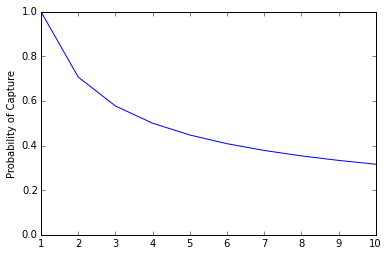

In [422]:
severities = [1,2,3,4,5,6,7,8,9,10]
probabilitycapture = [float(1)/np.sqrt(i) for i in severities]
probabilitycapture = [0] + probabilitycapture
plt.plot(probabilitycapture)
plt.axis([1, 10, 0, 1])
plt.ylabel('Probability of Capture')
plt.show()

Ok, now the thing everyone has been waiting for. Lets figure out how much we are actually saving Boston!

In [423]:
def getSavings(predictions, costs, adjust=False):
    savings = []
    for i in xrange(len(predictions)):
        prediction = predictions[i]
        actual = costs[i][0]
        key = costs[i][1]
        if prediction == 1 and actual == 1:
            for elt in crimeDictionary[key]:
                cost = float(elt['COST'])
                severity = float(elt['SCORE'])
                if adjust:
                    if not math.isnan(cost) and severity > 0:
                        savings.append(cost * (float(1)/np.sqrt(severity)) - float(costOfPolice))
                else:
                    if not math.isnan(cost) and severity > 0:
                        savings.append(cost - float(costOfPolice))
        elif prediction == 1 and actual == 0:
            savings.append(-costOfPolice)
        elif prediction == 0 and actual == 1:
            for elt in crimeDictionary[key]:
                cost = float(elt['COST'])
                severity = float(elt['SCORE'])
                if adjust:
                    if not math.isnan(cost):
                        savings.append(-cost)
        else:
            savings.append(0)
    return sum(savings)

In [424]:
test_set_savings_unadjusted = getSavings(bestRFPreds, costsTest, adjust=False)
test_set_savings_unadjusted

51046756.0

In [425]:
test_set_savings_adjusted = getSavings(bestRFPreds, costsTest, adjust=True)
test_set_savings_adjusted

14077637.903017813

In [426]:
XTrainProbs = optimalRF.predict_proba(X_train)
XTrainPreds = thresholdPredictions(best_t_rf, XTrainProbs)

In [427]:
training_set_savings_unadjusted = getSavings(XTrainPreds, costsTrain)
training_set_savings_unadjusted

209099899.0

In [428]:
training_set_savings_adjusted = getSavings(XTrainPreds, costsTrain, adjust=True)
training_set_savings_adjusted

58119638.675975308

So, in theory what would be our total savings if we had a classifier this accurate during the entire period spanning our dataset and we used the adjusted savings? 

We could either extrapolate the value by noting that our savings are a little more than $6 million over just the test set and the test set is roughly 1/5 of the total set, so our savings over the entire time period would be:

In [429]:
test_set_savings_adjusted * float(1)/((float(len(X_test)))/float(len(X)))

67437057.861896679

Alternatively, we could just use our predictions over the training set (which may be slightly biased so we can compare them to what we got above) and add them to our savings over the test set.

In [430]:
training_set_savings_adjusted + test_set_savings_adjusted

72197276.578993127

Anyway you slice it, it seems that even our conservative adjusted figures are able to save Boston about __67 million dollars __ in the few years of data we look at.

Just for fun, lets take a look and see what the result would be if Police could effectively act with 100% success rate on every piece of intelligence our machine learning algorithm produces:

In [365]:
training_set_savings_unadjusted + test_set_savings_unadjusted

259337347.0

Not bad at all!!!

# Conclusion

In this part of the project, we try to predict whether or not a crime will occur in a given location at a given time based on a set of dynamic factors that we received in previous parts of the project. Ultimately, this type of data could be incredibly helpful for police in order to dynamically allocate their patrols to the most threat-prone areas based on the changing variables of the day.

Based our analysis, we were able to find out that we could do 1) a good job predicting WHETHER or NOT a crime was going to occur but 2) not a great job on predicting how many crimes would occur. That is ok, however, as we are able to show that the classifier that does the best job at predicting the binary outcome (Random Forest optimized over our training data) does a fantastic job at saving the Boston Police Department money.

There are a number of considerations that one should look into before "blindly" accepting our results -- it may be a an oversimplification to say that the cost of additional police is just the additional hourly wage paid to the officers, and it may also be an optimistic oversimplification to say that if cops know when/where a crime is going to occur, they can prevent it with the probabilities discussed above. However, none the less, we feel that the vast majority of our assumptions were grounded in intensive research and are fair to be considered over a vast range of potential scenarios. At the end of the day, the number we get of saving the Boston Police Department a potential of __ 67 million dollars __ over 3 and a half years is something we believe __ at least __ indicates that this is a direction the department could benefit from exploring further and hopefully invites future work into the space.  